In [131]:
import torch
from torchvision import transforms
from matplotlib import pyplot as plt
from models import TCNmodel

train_data = torch.load('tensor.pt')
train_data=train_data.transpose(1,2)
print(train_data.shape)
preprocess = transforms.Compose([
    #transforms.Resize([41,360,640]),
    #transforms.CenterCrop(299),
    #transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_sample = preprocess(train_data)




torch.Size([1, 41, 3, 360, 640])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


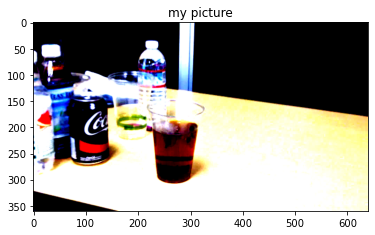

0
torch.Size([41, 3, 360, 640])


0.175

In [132]:

plt.imshow(train_sample[0,40,:,:,:].transpose(0,2).transpose(0,1))
plt.title('my picture')
plt.show()

for i,data in enumerate(train_sample):
    print(i)
    print(data.shape)
7/40

In [133]:
model=TCNmodel()


Using cache found in C:\Users\Think/.cache\torch\hub\pytorch_vision_v0.10.0


In [134]:
with torch.no_grad():
    output = model(train_data[0,:,:,:])
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output.shape)


torch.Size([41, 32])


In [141]:
from random import randrange
import numpy as np

anchor = output;
print(anchor.shape)
alpha = 0.2 # 7/41 ~0.2s
idx = np.arange(41)
posindex = np.zeros(41)
for i in range(41):
    p = randrange(-1,1)
    if p ==-1:
        posindex[i]=-1
    else:
        posindex[i]=1

posindex[0]=1
posindex[-1]=-1
posindx = idx+posindex
print(posindex)
pos_sample = output[posindex,:]

negindex = np.zeros(41)
for i in range(41):
    p = randrange(0,41)
    while p<i+2 & p>i-2:
        p=randrange(0,41)
       # print(p)
    negindex[i]=p
print(negindex)
neg_sample = output[negindex,:]

triplet_loss = torch.nn.TripletMarginLoss(margin=0, p=2)
corr=torch.mm(output,output.transpose(0,1))
loss = triplet_loss(anchor, pos_sample, neg_sample)
print(loss)
print(corr)
print(output)

torch.Size([41, 32])
[ 1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1. -1.  1.  1.  1. -1.  1.
  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1.  1.
  1. -1. -1. -1. -1.]
[33. 26.  7. 31. 15. 28. 40. 24. 22. 18. 22.  8. 21. 31. 14. 37. 18.  6.
 20.  7.  6. 23.  4. 21. 37. 24. 28. 33. 35. 27. 36. 13. 29. 28.  2.  7.
 32.  8.  3. 31. 14.]
tensor(0.0013)
tensor([[0.3645, 0.3645, 0.3645,  ..., 0.3650, 0.3650, 0.3647],
        [0.3645, 0.3644, 0.3645,  ..., 0.3649, 0.3649, 0.3646],
        [0.3645, 0.3645, 0.3645,  ..., 0.3650, 0.3650, 0.3647],
        ...,
        [0.3650, 0.3649, 0.3650,  ..., 0.3655, 0.3655, 0.3652],
        [0.3650, 0.3649, 0.3650,  ..., 0.3655, 0.3655, 0.3652],
        [0.3647, 0.3646, 0.3647,  ..., 0.3652, 0.3652, 0.3649]])
tensor([[ 0.0968, -0.1638, -0.1158,  ...,  0.1440,  0.0771,  0.0978],
        [ 0.0969, -0.1634, -0.1164,  ...,  0.1440,  0.0767,  0.0978],
        [ 0.0964, -0.1637, -0.1163,  ...,  0.1438,  0.0764,  0.0977],
        ...,
       

In [150]:
def train(train_loader, net, optimizer, criterion):
    """
    Trains network for one epoch in batches.

    Args:
        train_loader: Data loader for training set.
        net: Neural network model.
        optimizer: Optimizer (e.g. SGD).
        criterion: Loss function (e.g. cross-entropy loss).
    """
  
    avg_loss = 0
    correct = 0
    total = 0

    # iterate through batches
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        anchor = outputs
        
        idx = np.arange(41)

        # positve
        posindex = np.zeros(41)
        for i in range(41):
            p = randrange(-1,1)
            if p ==-1:
                posindex[i]=-1
            else:
                posindex[i]=1

        posindex[0]=1
        posindex[-1]=-1
        posindx = idx+posindex
        positive = outputs[posindex,:]
        
        # negative
        negindex = np.zeros(41)
        for i in range(41):
            p = randrange(0,41)
            while p<i+2 & p>i-2:
                p=randrange(0,41)
       # print(p)
            negindex[i]=p

        negative = outputs[negindex,:]
        
        
        
        alpha = 0.2
        loss = criterion(anchor,positive,negative)
        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        avg_loss += loss

    return avg_loss/len(train_loader)

In [151]:
from tqdm import tqdm
epochs = 100

# Create instance of Network
net = TCNmodel()

# Create loss function and optimizer
criterion = torch.nn.TripletMarginLoss(margin=0.2, p=2)
optimizer = torch.optim.SGD(net.parameters(), lr=5e-1)

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train(train_sample,net,optimizer,criterion)




Using cache found in C:\Users\Think/.cache\torch\hub\pytorch_vision_v0.10.0
 36%|█████████████████████████████▏                                                   | 36/100 [16:58<30:09, 28.28s/it]


KeyboardInterrupt: 